## Imports and constants

In [1]:
import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from onix.helpers import data_identifier, console_bold

In [36]:
name = "Transmission"
analysis_number = None
identifier = None

In [108]:
class TransmissionRun:
    def __init__(self, data_and_header, frequency_jump_threshold_GHz=0.1):
        self._data, self._header = data_and_header
        self._average_datapoints()
        self._get_valid_frequency_range()
        self._filter_frequency_jumps(frequency_jump_threshold_GHz)

    def _average_datapoints(self):
        self.time = self._data["times"]
        self.frequency_GHz = self._data["frequency_after_GHz"]
        self.V_transmission = np.average(self._data["V_transmission"], axis=1)
        self.V_monitor = np.average(self._data["V_monitor"], axis=1)
        self.V_ratio = self.V_transmission / self.V_monitor

    def _get_valid_frequency_range(self):
        self.valid_freq_mask = self.frequency_GHz > 0
        valid_freqs = self.frequency_GHz[self.valid_freq_mask]
        self.valid_frequency_range_GHz = (np.min(valid_freqs), np.max(valid_freqs))

    def _filter_frequency_jumps(self, frequency_jump_threshold_GHz):
        freq_differences = np.abs(np.ediff1d(self.frequency_GHz))
        below_threshold_next = freq_differences < frequency_jump_threshold_GHz
        below_threshold_previous = np.roll(below_threshold_next, shift=1)
        mask = np.bitwise_and(below_threshold_next, below_threshold_previous)
        mask = np.append(mask, False)
        mask[0] = False
        self.frequency_jump_mask = np.bitwise_and(mask, self.valid_freq_mask)

    def bin_data(self, bin_width_GHz = 5):
        mask = self.frequency_jump_mask
        num_bins = int((self.valid_frequency_range_GHz[1] - self.valid_frequency_range_GHz[0]) / bin_width_GHz)
        if num_bins == 0:
            num_bins = 1
        means, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio[mask], statistic="mean", bins=num_bins
        )
        stds, bin_edges, binnumber = st.binned_statistic(
            self.frequency_GHz[mask], self.V_ratio[mask], statistic="std", bins=num_bins
        )
        occurrences = np.bincount(binnumber)[1:]
        self.V_ratio_binned_avg = means
        self.V_ratio_binned_err = stds / np.sqrt(occurrences)
        self.frequency_binned = bin_edges[1:] - bin_edges[1] + bin_edges[0]

In [86]:
def add_label(ax, x=0.02, y=1.1):
    ax.text(x, y, identifier, transform=ax.transAxes)

## Setup

In [109]:
data_numbers = [45, 46, 47, 48, 49]
frequency_jump_threshold_GHz = 0.1
data = dict([(
    kk,
    TransmissionRun(get_experiment_data(kk), frequency_jump_threshold_GHz)
) for kk in data_numbers])

In [74]:
if input(f"Create new analysis folder? (y/{console_bold('n')}) ") == "y":
    analysis_number = open_analysis_folder(name)
else:
    if input(f"Keep current analysis number of {analysis_number}? ({console_bold('y')}/n) ") == "n":
        analysis_number = int(input("Enter analysis number: "))
identifier = "data " + data_identifier(data_numbers) + ", analysis " + data_identifier([analysis_number])
print(f"Current analysis number is {analysis_number}")

Create new analysis folder? (y/n) n
Keep current analysis number of 39? (y/n) 
Current analysis number is 39


## Initial plot

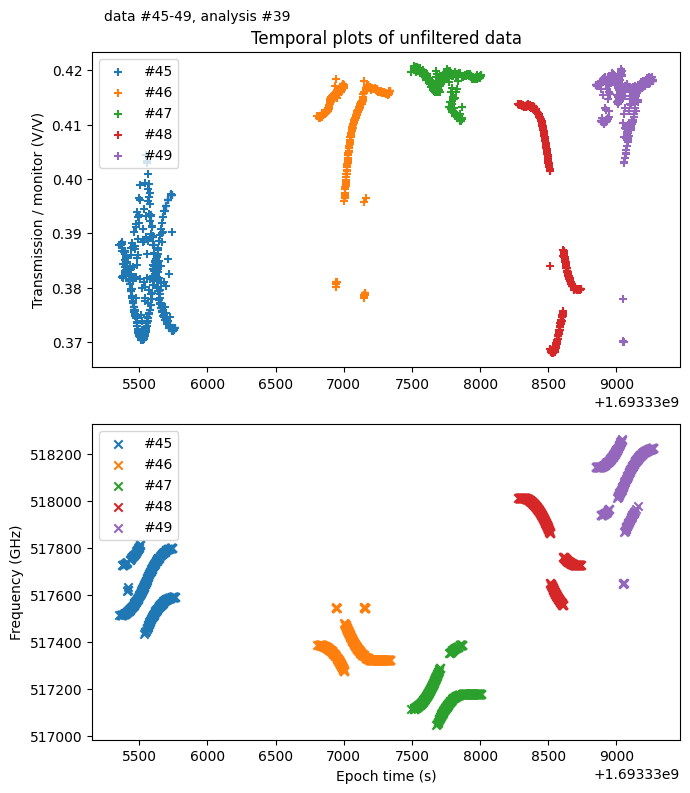

In [92]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(7, 8))
add_label(ax)
ax1.set_xlabel("Epoch time (s)")
ax.set_ylabel("Transmission / monitor (V/V)")
ax1.set_ylabel("Frequency (GHz)")
ax.set_title("Temporal plots of unfiltered data")
f_min = np.infty
f_max = -np.infty
for kk in data_numbers:
    run = data[kk]
    ax.scatter(run.time, run.V_ratio, marker="+", label=f"#{kk}")
    ax1.scatter(run.time, run.frequency_GHz, marker="x", label=f"#{kk}")
    if run.valid_frequency_range_GHz[0] < f_min:
        f_min = run.valid_frequency_range_GHz[0]
    if run.valid_frequency_range_GHz[1] > f_max:
        f_max = run.valid_frequency_range_GHz[1]
spacing = 0.05 * (f_max - f_min)
f_min -= spacing
f_max += spacing
ax1.set_ylim(f_min, f_max)
ax.legend()
ax1.legend()
plt.tight_layout()

plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_temporal.pdf")
)

plt.show()

## V_ratio plot

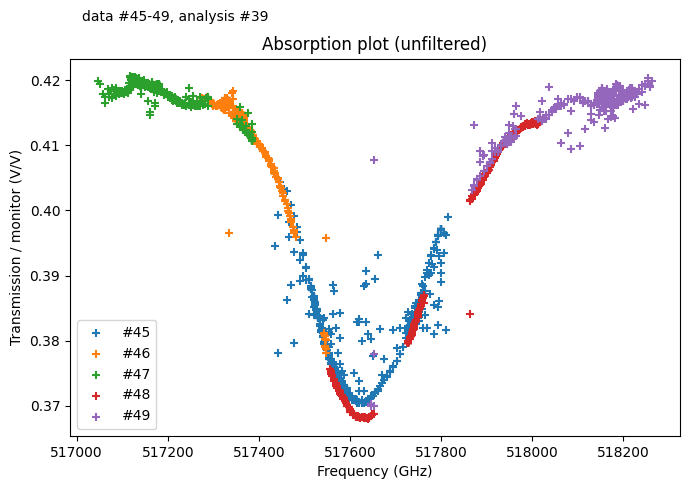

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (unfiltered)")
for kk in data_numbers:
    run = data[kk]
    ax.scatter(
        run.frequency_GHz[run.valid_freq_mask],
        run.V_ratio[run.valid_freq_mask],
        marker="+",label=f"#{kk}"
    )
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_unfiltered_V_ratio.pdf")
)
plt.show()

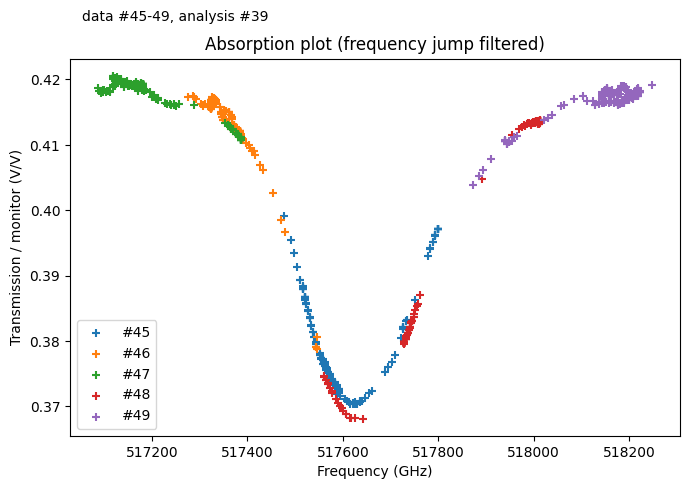

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (frequency jump filtered)")
for kk in data_numbers:
    run = data[kk]
    ax.scatter(
        run.frequency_GHz[run.frequency_jump_mask],
        run.V_ratio[run.frequency_jump_mask],
        marker="+",label=f"#{kk}"
    )
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_jump_filtered_V_ratio.pdf")
)
plt.show()

## Binned plot

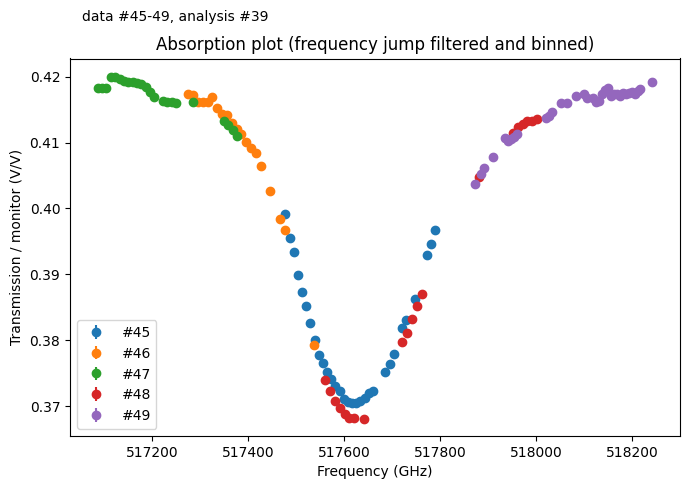

In [119]:
bin_width_GHz = 10
for kk in data_numbers:
    data[kk].bin_data(bin_width_GHz)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
add_label(ax)
ax.set_ylabel("Transmission / monitor (V/V)")
ax.set_xlabel("Frequency (GHz)")
ax.set_title("Absorption plot (frequency jump filtered and binned)")
for kk in data_numbers:
    run = data[kk]
    ax.errorbar(
        run.frequency_binned,
        run.V_ratio_binned_avg,
        run.V_ratio_binned_err,
        marker="o", label=f"#{kk}", ls="none",
    )
ax.legend()
plt.tight_layout()
plt.savefig(
    get_analysis_file_path(analysis_number, str(analysis_number) + "_binned_V_ratio.pdf")
)
plt.show()